In [10]:

from transformers import Owlv2Processor, Owlv2ForObjectDetection
from huggingface_hub import hf_hub_download
from PIL import Image, ImageDraw,ImageFont
import subprocess
import torch

from openai import OpenAI
import os
from include.gpt_caller import *

from datetime import datetime
import whisper
import random

from moviepy.editor import VideoFileClip
import os
from PIL import Image
import numpy as np

import base64
import requests
from openai import OpenAI

In [3]:
class CommandNode:
    def __init__(self, command, parent=None):
        self.command = command
        self.parent = parent
        self.children = []
    
    def add_child(self,child_node):
        self.children.append(child_node)
        child_node.parent = self

    def add_child_to_node(self,parent_command , child_node):
        node=self.get_child(parent_command)
        if node:
            node.add_child(child_node)
            return node
        else:
            return None

    def get_child(self,command,recursive=False):
        if self.command == command:
            return self
        if recursive:
            for child in self.children:
                if child.command == command:
                    return child
                else:
                    result = child.get_child(command,recursive)
                    if result:
                        return result
            return None
        else:
            for child in self.children:
                if child.command == command:
                    return child
        return None
    
    def remove_child(self,command,recursive=False):
        if recursive:
            for child in self.children:
                if child.command == command:
                    self.children.remove(child)
                    return
                else:
                    child.remove_child(command,recursive)
            return None
        else:
            for child in self.children:
                if child.command == command:
                    self.children.remove(child)
                    return
        return None
    def create_child(self,command):
        node = CommandNode(command,self)
        node.command = command
        return node
    

    


In [61]:
from PIL import Image, ImageDraw, ImageFont
class Detector:
    """Class that implements Owl v2 for object detection."""
    def __init__(self):
        print("cuda is available:",torch.cuda.is_available())
        self.processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
        self.model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to("cuda")
    
    def detect(self, image, texts):
        inputs = self.processor(texts, image, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = self.model(**inputs)
        # Convert model outputs to COCO API format.
        
        target_sizes = torch.Tensor([image.size[::-1]])
        results = self.processor.post_process_object_detection(outputs=outputs, threshold=0.25)
        box=results[0]["boxes"]*960

        a=image.size[0]/960
        box *= a 

        results[0]["boxes"]=box
        return results
    

    def displayBoundingBox(self, image, results, text):
        boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
        # Draw bounding boxes and labels on the image.
        #draw = ImageDraw.Draw(padded_image)
        draw=ImageDraw.Draw(image)
        for box, score, label in zip(boxes, scores, labels):
            box = [round(i, 2) for i in box.tolist()]
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
            font_size = 40
            font = ImageFont.load_default()
            draw.text(xy=(x1, y1), text=str(i), font=font, fill="black")
            i += 1

        return image#padded_image

In [5]:
class UserInputManager:
    def __init__(self):

        self.content=[]
        self.transcribe_model = None
        
    def add_new_input(self,user_input):
        self.assign_id(user_input)
        self.content.append(user_input)
        return user_input.id
        
    def assign_id(self,user_input):
        user_input.id = f"{user_input.type}_{abs(hash(int(user_input.created_time.timestamp())))}"
        collision = True
        while collision:
            collision = False
            for content in self.content:
                if content.id == user_input.id:
                    collision = True
                    user_input.assign_id()
                    break
    def get_most_recent_input(self):
        if self.content:
            most_recent_input = self.content[0]
            for user_input in self.content:
                if user_input.created_time.timestamp() > most_recent_input.created_time.timestamp():
                    most_recent_input = user_input
            return most_recent_input
        else:
            return None
        
        
    def get_input_by_id(self,id):
        for user_input in self.content:
            if user_input.id == id:
                return user_input
        return None

    def search_input_by_keyword(self,keyword):
        results = []
        for user_input in self.content:
            if keyword in user_input.data:
                results.append(user_input.id)
        return results
          
    def transcribe_audio(self,id):
        if self.transcribe_model is None:
            self.transcribe_model =whisper.load_model("base")
        else:
            pass
        audio_input = self.get_input_by_id(id)
        if audio_input.type != "audio":
            raise TypeError("Invalid input type")
        result = self.model.transcribe(audio_input.audio_file)["text"]
        audio_input.data = result
        return result
    
    def downsample_video(self,id,fps=1):
        video_input = self.get_input_by_id(id)
        image_list=[]
        if video_input.type != "video":
            raise TypeError("Invalid input type")

        # Load the video
        video_clip = VideoFileClip(video_input.video_file)

        # Set the fps to 1
        downsampled_video = video_clip.set_fps(fps)
        

        # Save each frame as an image file
        for i, frame in enumerate(downsampled_video.iter_frames()):
            img = Image.fromarray(frame)
            img = img.resize((640, 480))
            image_list.append(img)        
        video_input.data = image_list
        return video_input.data
    
    def detect_objects(self,id,texts):
        user_input = self.get_input_by_id(id)
        user_input.request[texts[0]] = []
        if user_input.type == "video":
            detector = Detector()
            for image in user_input.data:
                results = detector.detect(image, texts)
                #print(results)
                labeled_image=detector.displayBoundingBox(image,results,texts)
                #image.show()
                user_input.request[texts[0]].append({"boxes":results[0]["boxes"].tolist(),"image":labeled_image})
        
        elif user_input.type == "RGBD_set":
            detector = Detector()
            user_input.request[texts[0]] = []
            for image, depth in user_input.data:
                results = detector.detect(image, texts)
                labeled_image=detector.displayBoundingBox(image,results,texts)
                user_input.request[texts[0]].append({"boxes":results[0]["boxes"].tolist(),"image":labeled_image})
            
        else:
            raise TypeError("Invalid input type")
        
        
        

class UserInput:
    def __init__(self):
        self.id=None
        self.created_time = datetime.now()
        self.type = None
        self.data=None
        self.request={}
class UserAudio(UserInput):
    #self.data is the transcribed text
    def __init__(self,file):
        super().__init__()
        self.type="audio"
        self.audio_file = file
        
class UserVideo(UserInput):
    #self.data is list of PIL images
    def __init__(self,file):
        super().__init__()
        self.type = "video"
        self.video_file = file

class UserRGBDSet(UserInput):
    #self.data is the list of tuples of (color_image, depth_image)
    def __init__(self,path_to_images):
        super().__init__()
        self.type = "RGBD_set"
        self.image_set_dir = path_to_images
        self.data=[]
        print(self.image_set_dir)
        color_path = os.path.join(self.image_set_dir,'color')
        print(color_path)
        depth_path = os.path.join(self.image_set_dir,'depth')

        # Get the list of png files in the color directory
        color_files = [f for f in os.listdir(color_path)]

        # Sort the files to ensure they match with the depth files
        color_files.sort()

        # Load the images and .npy files into tuple pairs
        for filename in color_files:
            # Load the PIL image
            image = Image.open(os.path.join(color_path, filename))

            # Load the corresponding .npy file
            #depth_filename = os.path.splitext(filename)[0] + '.npy'
            #depth = np.load(os.path.join(depth_path, depth_filename))

            # Add the pair to the list
            self.data.append((image, 0))       
        




In [6]:
class gpt_caller:
    def __init__(self):
        self.client = OpenAI()
    
    def encode_image(self,image):
        if type(image) == str:
            with open(image, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        else:
            temp_image_path = "./temp.png"
            image.save(temp_image_path)
            return self.encode_image(temp_image_path)

    def create_prompt(self, user_prompt_list=[],system_prompt_list=[]):
        messages = []
        content=[]
        for item in system_prompt_list:
            content.append({
                    "type": "text",
                    "text": item
                })
            

        messages.append({
            "role": "system",
            "content": content
        })
        
        content=[]

        for item in user_prompt_list:

            if type(item) == str:
                content.append({
                    "type": "text",
                    "text": item
                })
            
            else:
                base64_image=self.encode_image(item)

                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "low"

                    }
                })


        messages.append({
            "role": "user",
            "content": content
        })
        self.messages=messages

    def call(self):

        completion = self.client.chat.completions.create(
        model="gpt-4o",
        messages=self.messages,temperature=0
        )

        print(completion.choices[0].message)

        return completion.choices[0].message.content

Assume we have converted the speech to text

In [62]:
#x=UserInput()
#print(x.created_time)
#a=UserAudio("./audio.wav")

v=UserVideo("./video.mp4")

manager=UserInputManager()
manager.add_new_input(v)
print(v.id)
manager.downsample_video(v.id)
manager.detect_objects(v.id,["chair"])

v.request["chair"][3]["image"].show()
print(v.request["chair"][3]["boxes"])

video_1721382604
cuda is available: True
1.5
720
1.5
720
1.5
720
1.5
720
1.5
720
1.5
720
1.5
720
[[279.01531982421875, 111.62605285644531, 372.236572265625, 321.633544921875], [443.0264587402344, 114.27092742919922, 529.6223754882812, 345.4007263183594], [512.75732421875, 169.78945922851562, 640.0611572265625, 477.2221374511719], [72.6703109741211, 202.06744384765625, 255.2323455810547, 478.0032653808594]]


In [41]:
v.request["chair"][0]["image"].show()


In [7]:
manager=UserInputManager()

rgbd_Set=UserRGBDSet("./frames")
print(rgbd_Set.created_time)
print(rgbd_Set.image_set_dir)
manager.add_new_input(rgbd_Set)
print(rgbd_Set.id)

./frames
./frames/color
2024-07-19 17:15:06.264481
./frames
RGBD_set_1721380506


In [21]:
manager.detect_objects(rgbd_Set.id,["chair"])

cuda is available: True


In [24]:
rgbd_Set.request["chair"][3]["image"].show()


In [9]:
caller=gpt_caller()
system_prompt="You are an AI assistant that can help with identifiying requested item in an image. The options will be included in bounding boxes with an index. Pick the bounding box that contains requested item.return nothing but the number. Return -1 if not found."
user_prompt="Task is : which chair is occupied by a person."
caller.create_prompt([user_prompt,v.request["chair"][1]["image"]],system_prompt_list=[system_prompt])

response=caller.call()


ChatCompletionMessage(content='6', role='assistant', function_call=None, tool_calls=None)


In [10]:
x1, y1, x2, y2 = tuple(v.request["chair"][1]["boxes"][int(response)])

In [11]:
#cropped_image=v.request["trash-can"][3]["image"].crop((x1, y1, x2, y2))
cropped_image=v.data[1].crop((x1, y1, x2, y2))
cropped_image.show()

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    



In [16]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

In [17]:
print(sam.device)

cuda:0


In [18]:
image = cv2.cvtColor(np.array(cropped_image), cv2.COLOR_RGB2BGR)
predictor.set_image(image)

In [19]:
input_point = np.array([[image.shape[1] // 2, image.shape[0] // 2]])

input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

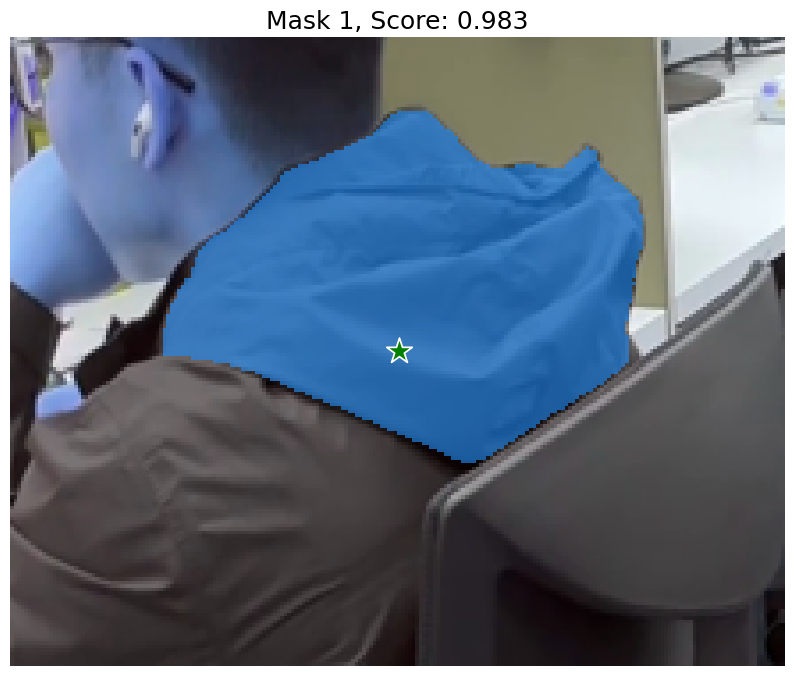

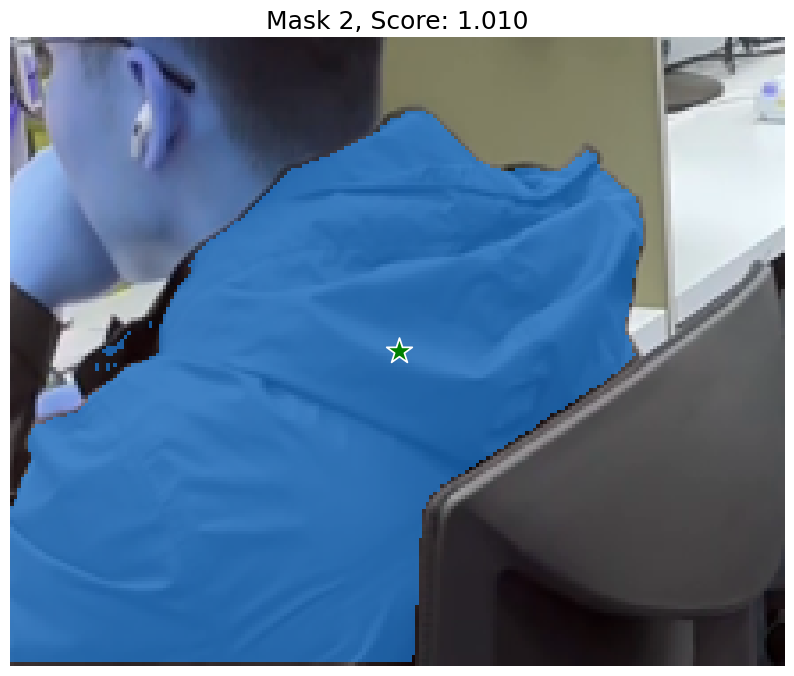

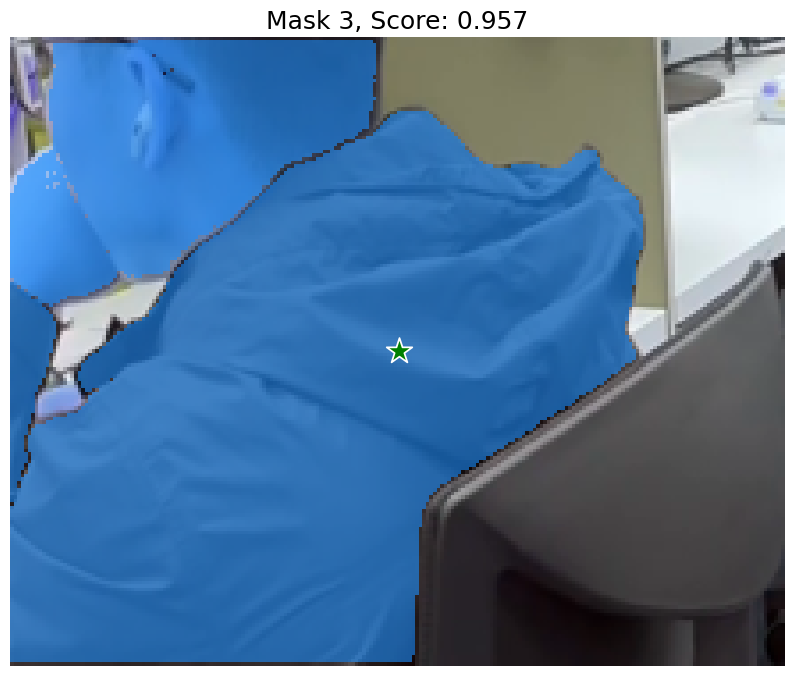

In [20]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

In [21]:
masks = mask_generator.generate(image)